# COMP-4360 - Machine Learning - Project

---
## Construct ESN class and functions
Import required packages, make sure current environment has matplotlib and numpy packages<br>

In [691]:
# make sure current environment has matplotlib package
import matplotlib.pyplot as plt
# make sure current environment has numpy package
import numpy as np
# make sure plots are correctly displayed in the notebook
%matplotlib inline

Read dataset, there are two .txt files in folder which are 2sin.txt and lorenz.txt<br>
The following func is aim to load one dataset and return it as array

In [692]:
def read_dataset(datasetName):
    dataset = np.loadtxt(datasetName)
    #print(dataset)
    return dataset

The following class is aim to construct echo state network, including five methods<br>
1. constructor()
<br>receive N_i, N_r, N_o as parameter, intialize W_i, W_r, W_o
2. reservoirs()
<br>train ESN by training set, collect states x and save them in matrix X, return X 
3. ridgeRegression()
<br>calculate read-out weights W_o by means of ridge regression, return W_o
4. predict()
<br>put read-out weights W_o back to network, run ESN by testing set, use k-step ahead forecasting to get outputs
5. calculateError()
<br>calculate mean square error

More details about method parameters and attributes i left in the comments.

In [693]:
class ESN:
    """
        __init__(self, N_i, N_r, N_o)
        
        args:
            N_i (int): input dimension
            N_r (int): the number of neurons in the recurrent layer(number of reservoirs)
            N_o (int): dimension of outputs
            
        attributes:
            N_i (int): input dimension
            N_r (int): the number of neurons in the recurrent layer(number of reservoirs)
            N_o (int): dimension of outputs
            W_r (np.array matrix): recurrent layer weight matrix, [N_r x N_r]
            W_i (np.array matrix): input-to-reservoir weight matrix, [N_r x N_i]
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
    """
    def __init__(self, N_i, N_r, N_o):   
        self.N_i = N_i
        self.N_r = N_r
        self.N_o = N_o
        # output key attributes
        #print("N_i: \n{}".format(self.N_i))
        #print("N_r: \n{}".format(self.N_r))
        #print("N_o: \n{}".format(self.N_o))
        
        # W_i belongs to [N_r x N_i], drawn from a uniform distribution in [−1, 1]
        self.W_i = np.random.uniform(-1, 1, (self.N_r, self.N_i))
        
        # W_r belongs to [N_r x N_r], drawn from a uniform distribution in [−1, 1],
        # then calculate spectral radius
        self.W_r = np.random.uniform(-1, 1, (self.N_r, self.N_r))
        spectralRadius = np.max(np.abs(np.linalg.eigvals(self.W_r)))
        scalar_a = 0.8
        self.W_r = (self.W_r/spectralRadius)*scalar_a
        
        # W_o belongs to [N_o x N_r], 
        # typically obtained by solving a regularized least-square regression problem
        self.W_o = np.random.uniform(-1, 1, (self.N_o, self.N_r))
    
    """
        reservoirs(self, dataset, train_size)
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            
        attributes:
            x (np.array matrix): the sequence of states, [N_r x N_i]
            X (np.array matrix): collect the resulting N states xi in a matrix X, [train_size x N_r]
            t (int): time-step t
            u (np.array matrix): element at timestep ti, called input, [1 x 1]
    """
    def reservoirs(self, dataset, train_size):
        x = np.zeros(( self.N_r, self.N_i ))
        X = np.zeros(( train_size, self.N_r ))
        
        # start to train ESN
        for t in range(train_size):
            u = np.array([[ dataset[t] ]])
            # standard ESN model:
            #
            #      x_ti = φ( W_r x_t(i-1) + W_i u )
            #      z_ti = W_o x_ti 
            #                       
            # select tanh as activation function
            # since we don't have W_o, we collect states x and save in matrix X first
            # implementation:
            x = np.tanh( np.dot(self.W_r, x) + np.dot(self.W_i, u) )
            # since x is [N_r x N_i], transpose it as [N_i x N_r], then save it in matrix X
            X[t,:] = x.T
            
        # output key attributes
        #print("X: \n{}".format(X))
        return X
    
    """
        ridgeRegression(self, dataset, train_size, X)
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            X (np.array matrix): collect the resulting N states xi in a matrix X, [train_size x N_r]
            
        attributes:
            T (array): corresponding target
            lambta (int): regularization coefficient, lambda
            I (np.array matrix): identity matrix, [N_r x N_r]
            W (np.array matrix): ridge regression closed-form solution, [N_r x N_o]
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
    """
    def ridgeRegression(self, dataset, train_size, X):
        T = dataset[:train_size]
        # set regularization coefficient
        lambta = 1e-7
        I = np.identity(self.N_r)
        
        # closed-form solution:
        #
        #      W = (XTX + λI)^(-1) XT t
        #
        # implementation:
        W = np.dot(np.dot( np.linalg.inv( np.dot(np.transpose(X), X) + lambta * I ), np.transpose(X) ), T)
        self.W_o = np.transpose(W)
        
        # output key attributes
        #print("W_o: \n{}".format(self.W_o))
        return self.W_o
    
    """
        predict(self, dataset, train_size, test_size, W_o, X)
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            test_size (int): size of testing set
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
            X (np.array): collect the resulting N states xi in a matrix X, [train_size x N_r]
            k (int): k of k-step ahead forecasting, output to be predicted is the value of the time series at time t+k
            
        attributes:
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
            u (np.array matrix): element at timestep, called input, [1 x 1]
            x (np.array matrix): the sequence of states, [N_r x N_i]
            Z (np.array matrix): collect the resulting N states zi in a matrix Z, [N_o, test_size]
            z (np.array matrix): [N_o x N_i]
    """
    def predict(self, dataset, train_size, test_size, W_o, X, k, n):
        self.W_o = W_o
        u = np.array([[ dataset[train_size] ]])
        x = np.transpose( np.array([ X[train_size-1,:] ]) )
        Z = np.zeros([self.N_o, test_size+k])
        
        # run ESN and predict
        for t in range(test_size):
            # standard ESN model:
            #
            #      x_ti = φ( W_r x_t(i-1) + W_i u )
            #      z_ti = W_o x_ti 
            #                             
            # same as above method, select tanh as activation function
            # we already have W_o from ridgeRegression method, thus we can keep going on
            # implementation:
            x = np.tanh( np.dot(self.W_r, x) + np.dot(self.W_i, u) )
            z = np.dot( self.W_o, x )
            # by k-step ahead forecasting, jump k in testing set
            u = np.array([[ dataset[train_size+t+k] ]])
            Z[:, t] = z

        # output key attributes
        #print("Z:\n{}".format(Z))
        return Z
    
    """
        calculateError(self, dataset, train_size, error_size, Z):
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            error_size (int): size of measurement error range
            Z (np.array matrix): collect the resulting N states zi in a matrix Z, [N_o, test_size]
            
        attributes:
            t_val : target value
            p_val : predicted value
            mse : mean square error
    """
    def calculateError(self, dataset, train_size, error_size, Z, k):
        t_val = dataset[ train_size+k : train_size+error_size+k ]
        #p_val = Z[0, 0:error_size+k]
        p_val = Z[0, :error_size]
        
        # mean-squared Error (MSE):
        #
        #      MSE = 〈‖t − z‖^2〉
        #
        # implementation:
        mse = sum( np.square( t_val - p_val ) )  / error_size
        
        # output key attributes
        print('MSE = {}'.format(str( mse )))
        return mse
              

Call this function to run ESN

In [694]:
def runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n):
    """
    Load dataset
    """
    dataset = read_dataset(datasetName)
    
    """
    Initialize ESN with N_i, N_r, N_o, construct ESN
    """
    esn = ESN(N_i, N_r, N_o)
    
    """
    Set size of training set
    Then train ESN by training set and collect the resulting N states x into X
    """
    X = esn.reservoirs(dataset, train_size)
    
    """
    Calculate read-out weights W_o by means of ridge regression
    """
    W_o = esn.ridgeRegression(dataset, train_size, X)
    
    """
    After training ridge regression, get W_o, then put it back to ESN
    Run the trained ESN by testing set
    Collect output into Z by k-step ahead forecasting
    """
    Z = esn.predict(dataset, train_size, test_size, W_o, X, k, n)
    
    """
    Eventually, calculate mean square error
    """
    mse = esn.calculateError(dataset, train_size, error_size, Z, k)
    
    return dataset, X, W_o, Z, mse

Call this function to plot related diagrams

In [695]:
def plot_original(dataset):
    """
    Present original dataset
    """
    plt.figure(figsize=(15,4))
    plt.plot(dataset, 'red', linewidth=0.8)
    plt.title(r'Dataset')  

def plot_testing(train_size, test_size, Z):
    """
    Present targets and prediction outputs during testing process
    """
    plt.figure(figsize=(15,4))
    plt.plot(dataset[train_size+k:train_size+test_size+k], 'red', linewidth=2)
    plt.plot(Z.T, 'b', linewidth=0.8)
    plt.title(r'Targets and prediction outputs $\mathbf{Z}$')
    plt.legend(['Target', 'Prediction'])

def plot_states(X):
    """
    Present part of activation reservoirs states
    """
    plt.figure(figsize=(15,4))
    plt.plot(X[:400,:50])
    plt.title(r'Reservoirs states $\mathbf{x}(n)$')

def plot_Wo(N_r, W_o):
    """
    Present read-out weights during training process
    """
    plt.figure(figsize=(15,4))
    plt.bar( np.arange(N_r), W_o.T )
    plt.title(r'Read-out weights $\mathbf{W}^{out}$')

---
## Run ESN and present contents
After implementing ESN above, it's time to run ESN. Since there are two .txt files, i will present them separately
#### Load "2sin.txt", train ESN, predict output, calculate error
Default:

In [696]:
datasetName = "2sin.txt"
N_i = 1
N_r = 10
N_o = 1
train_size = 20
test_size = 800
error_size = 800
k = 1
n = 0
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
dataset = returnList[0]
X = returnList[1]
W_o = returnList[2]
Z = returnList[3]
mse = returnList[4]

MSE = 0.06522593673462375


#### Plot diagram
The first diagram presents the original dataset<br>
The second diagram presents targets and prediction outputs during testing process. Red line is targets, blue line is prediction outputs<br>
The third diagram presents reservoirs states<br>
The Fourth diagram presents read-out weights

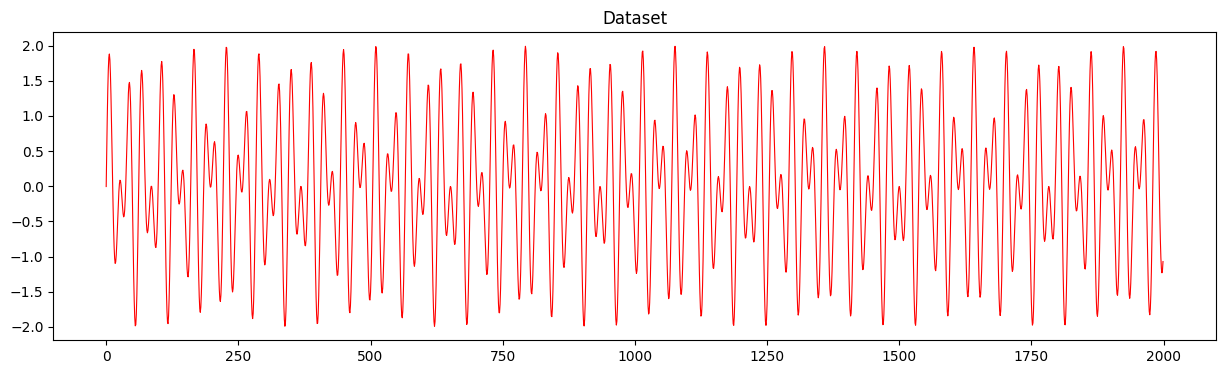

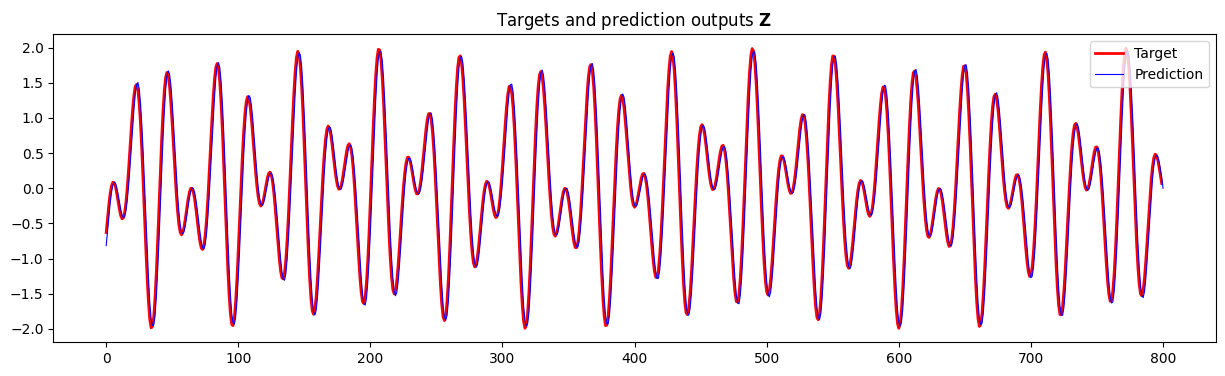

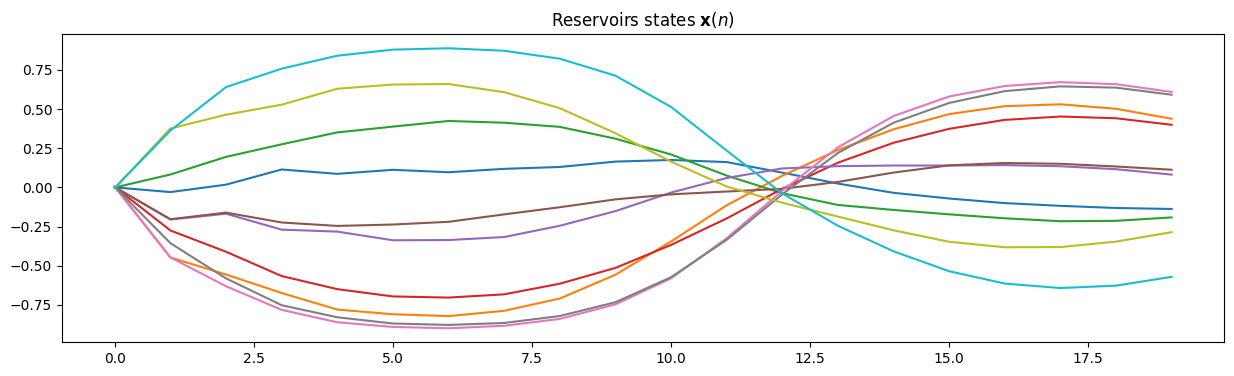

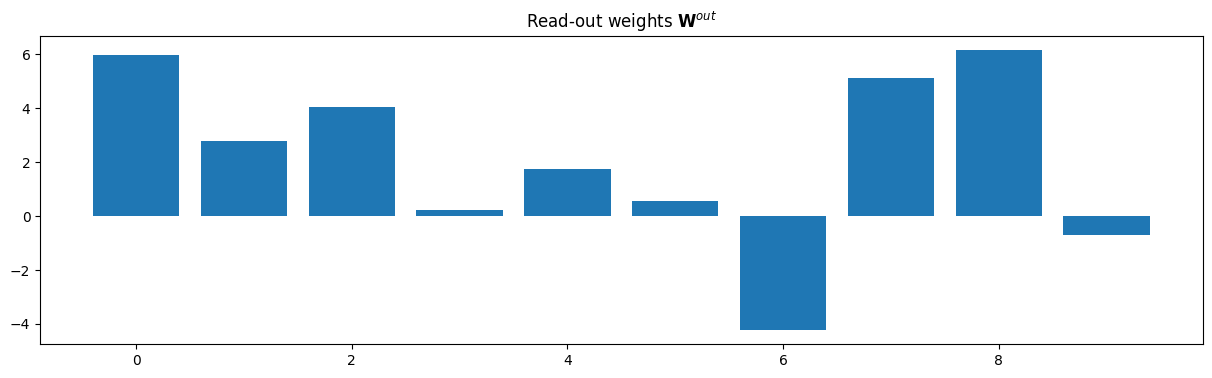

In [697]:
plot_original(dataset)
plot_testing(train_size, test_size, Z)
plot_states(X)
plot_Wo(N_r, W_o)

---
#### Load "lorenz.txt", train ESN, predict output, calculate error
Default:

In [710]:
datasetName = "lorenz.txt"
N_i = 1
N_r = 10
N_o = 1
train_size = 100
test_size = 2000
error_size = 2000
k = 1
n = 0
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
dataset = returnList[0]
X = returnList[1]
W_o = returnList[2]
Z = returnList[3]
mse = returnList[4]

MSE = 0.3226875515626083


#### Plot diagram
The first diagram presents the original dataset<br>
The second diagram presents targets and prediction outputs during testing process. Red line is targets, blue line is prediction outputs<br>
The third diagram presents reservoirs states<br>
The Fourth diagram presents read-out weights

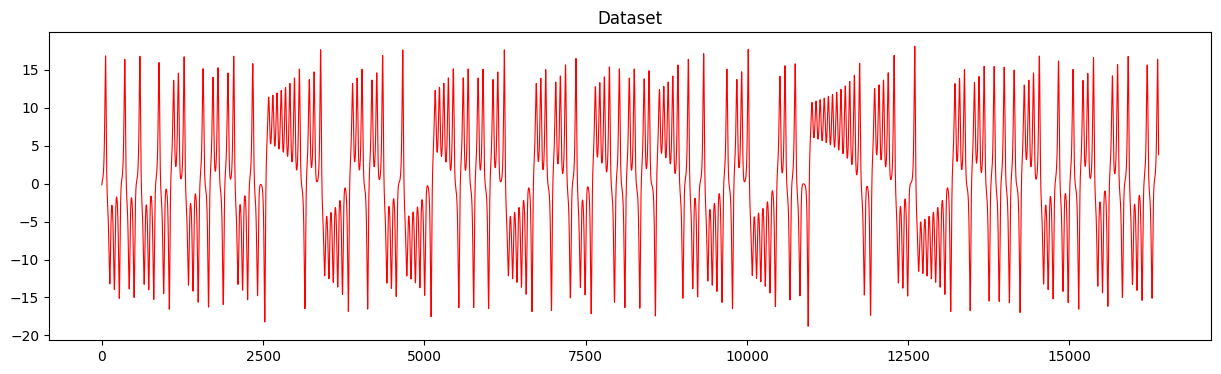

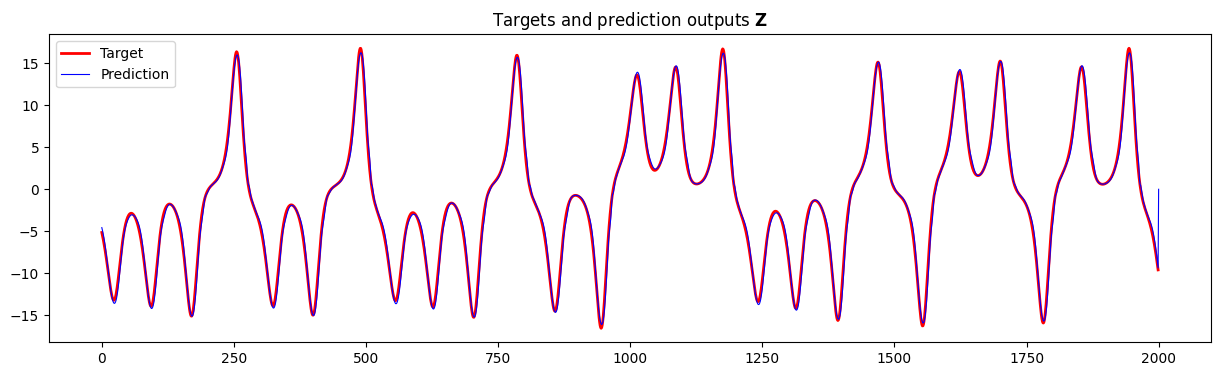

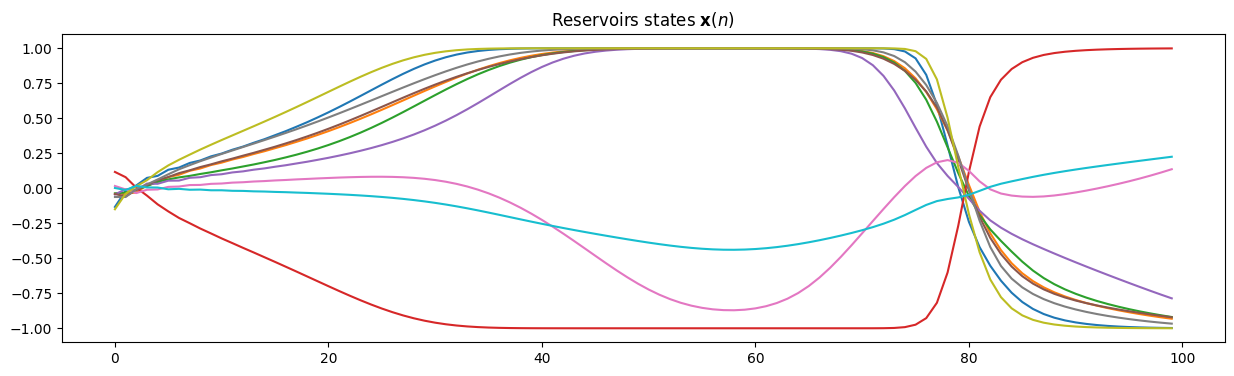

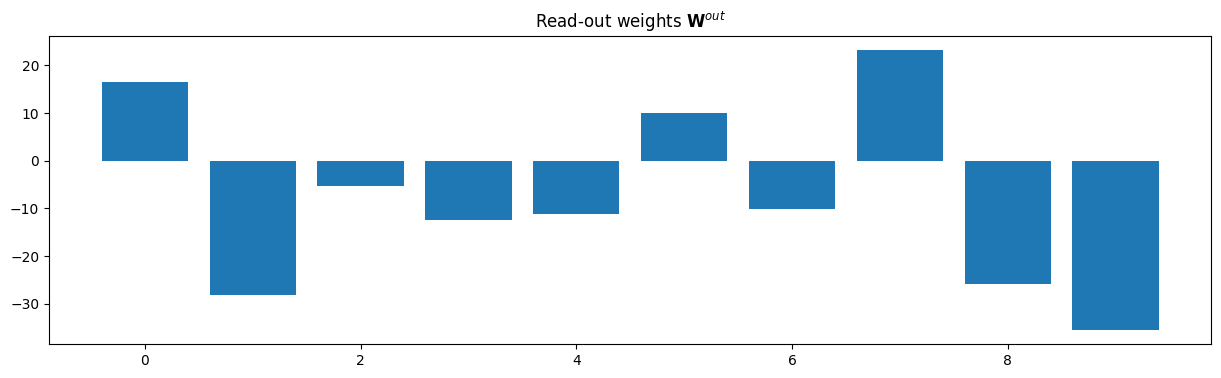

In [711]:
plot_original(dataset)
plot_testing(train_size, test_size, Z)
plot_states(X)
plot_Wo(N_r, W_o)

This is the end of the project. Thank you for watching.